Classifying Pneumonia From Chest X-Rays Using a CNN

# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os # gets the data directory

np.random.seed(42)
tf.random.set_seed(42)

# Loading Chest X-Ray Images (Pneumonia) Dataset

In [2]:
# Configure dataset paths
BASE_DIR = 'chest_xray'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Image parameters
IMG_HEIGHT = 150  # experiment with 150, 224, or 256
IMG_WIDTH = 150
BATCH_SIZE = 32
NUM_CLASSES = 2  # normal and pneumonia

# Check if directories exist
print("Checking dataset directories...")
for dir_path in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    if os.path.exists(dir_path):
        print(f"✓ Found: {dir_path}")
        classes = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
        print(f"  Classes: {classes}")
    else:
        print(f"✗ Missing: {dir_path} - Please check your path!")

Checking dataset directories...
✓ Found: chest_xray\train
  Classes: ['NORMAL', 'PNEUMONIA']
✓ Found: chest_xray\val
  Classes: ['NORMAL', 'PNEUMONIA']
✓ Found: chest_xray\test
  Classes: ['NORMAL', 'PNEUMONIA']


# Data Preprocessing & Augmentation

Data augmentation helps prevent overfitting by creating variations of training images.

In [3]:
# Data augmentation for training set (helps prevent overfitting)
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0,1]
    rotation_range=15,           # Randomly rotate images up to 15 degrees
    width_shift_range=0.1,       # Shift horizontally
    height_shift_range=0.1,      # Shift vertically
    shear_range=0.1,             # Shear transformation
    zoom_range=0.1,              # Zoom in/out
    horizontal_flip=True,        # Random horizontal flip
    fill_mode='nearest'
)

# Only rescaling for validation/test sets (NO augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # For 2 classes (binary classification)
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"\n{'='*50}")
print(f"Dataset Summary:")
print(f"{'='*50}")
print(f"Class indices: {train_generator.class_indices}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"{'='*50}")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Dataset Summary:
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Training samples: 5216
Validation samples: 16
Test samples: 624


# Visualize Sample Images

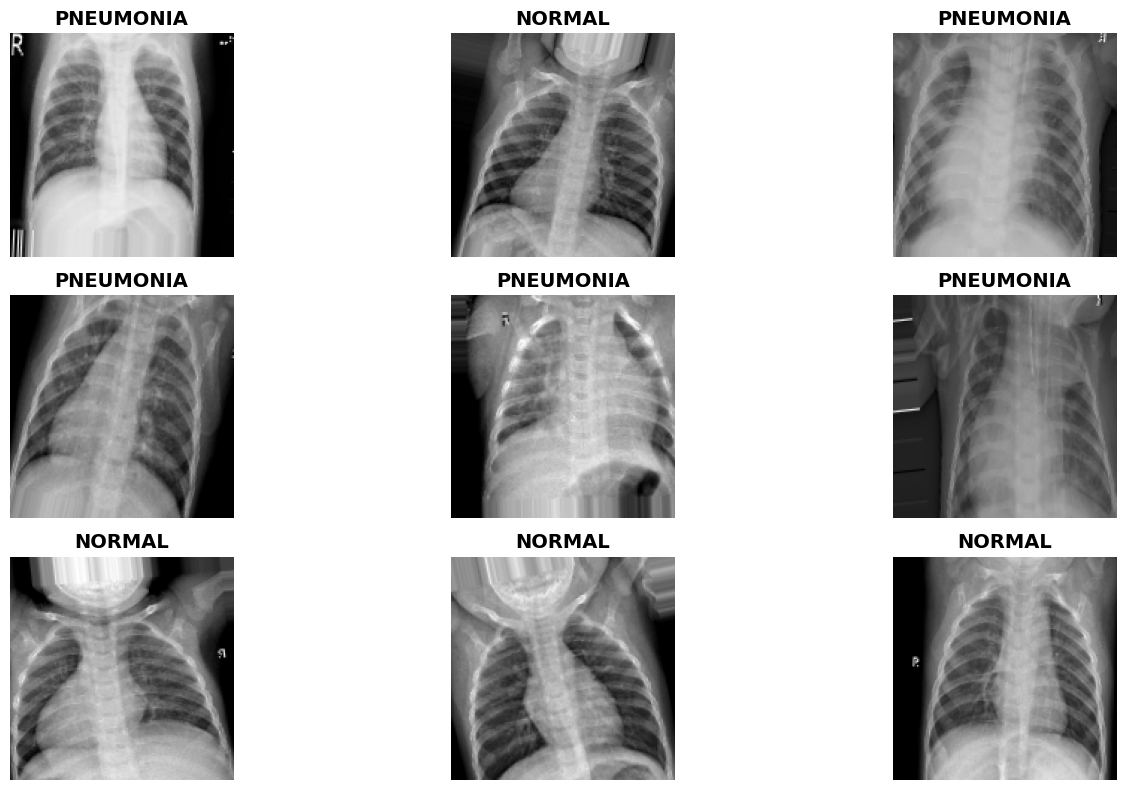

In [4]:
# Visualize sample images from training set
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(15, 8))
sample_images, sample_labels = next(train_generator)

for i in range(min(9, len(sample_images))):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    label_idx = int(sample_labels[i])
    plt.title(f'{class_names[label_idx]}', fontsize=14, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Build CNN Model

Creating a Convolutional Neural Network for binary classification (Normal vs Pneumonia).

In [5]:
def build_cnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    """
    Build a CNN model for pneumonia classification
    """
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Dense Layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        # Output Layer (binary classification: 0=NORMAL, 1=PNEUMONIA)
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Build the model
model = build_cnn_model()
print("✓ Model created successfully!")

✓ Model created successfully!


c:\Users\Light\Desktop\College\CECS-456-Project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 10,940,449 (41.73 MB)

 Trainable params: 10,938,785 (41.73 MB)

 Non-trainable params: 1,664 (6.50 KB)

# Compile the Model

In [7]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # For binary classification
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall')]
)

print("✓ Model compiled successfully!")

✓ Model compiled successfully!


# Setup Callbacks

Callbacks help improve training by:
- **EarlyStopping**: Stop if validation loss doesn't improve
- **ReduceLROnPlateau**: Lower learning rate when stuck
- **ModelCheckpoint**: Save the best model

In [8]:
# Setup callbacks for better training
callbacks = [
    # Stop training if validation loss doesn't improve
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate when stuck
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Save best model
    ModelCheckpoint(
        'Model1_best_pneumonia_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("✓ Callbacks configured!")

✓ Callbacks configured!


# Train the Model

This will take some time (10-20 minutes depending on your computer). The model will train for up to 25 epochs, but may stop early if it stops improving.

In [9]:
# Train the model
EPOCHS = 25

print(f"Starting training for up to {EPOCHS} epochs...")
print(f"Training on {train_generator.samples} images")
print(f"Validating on {val_generator.samples} images\n")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*50)
print("✓ Training completed!")
print("="*50)

Starting training for up to 25 epochs...
Training on 5216 images
Validating on 16 images

Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.7721 - loss: 0.5510 - precision: 0.9230 - recall: 0.7483
Epoch 1: val_accuracy improved from None to 0.50000, saving model to Model1_best_pneumonia_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 124s 738ms/step - accuracy: 0.8353 - loss: 0.4176 - precision: 0.9402 - recall: 0.8312 - val_accuracy: 0.5000 - val_loss: 3.2770 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9003 - loss: 0.2722 - precision: 0.9461 - recall: 0.9200
Epoch 2: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 694ms/step - accuracy: 0.9082 - loss: 0.2404 - precision: 0.9420 - recall: 0.9339 - val_accuracy: 0.5000 - val_loss: 8.2147 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.9243 - loss: 0.2200 - precision: 0.9538 - recall: 0.9456
Epoch 3: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 691ms/step - accuracy: 0.9220 - loss: 0.2155 - precision: 0.9474 - recall: 0.9476 - val_accuracy: 0.5000 - val_loss: 4.7464 - val_precision: 0.5000 - val_recall

163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 696ms/step - accuracy: 0.9335 - loss: 0.1839 - precision: 0.9528 - recall: 0.9579 - val_accuracy: 0.6250 - val_loss: 0.7013 - val_precision: 0.6250 - val_recall: 0.6250 - learning_rate: 0.0010
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.9436 - loss: 0.1677 - precision: 0.9630 - recall: 0.9610
Epoch 5: val_accuracy did not improve from 0.62500
163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 724ms/step - accuracy: 0.9410 - loss: 0.1680 - precision: 0.9598 - recall: 0.9608 - val_accuracy: 0.5000 - val_loss: 1.3390 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.9392 - loss: 0.1624 - precision: 0.9547 - recall: 0.9637
Epoch 6: val_accuracy did not improve from 0.62500
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 736ms/step - accuracy: 0.9402 - loss: 0.1622 - precision: 0.9595 - recall: 0.9600 - val_accuracy: 0.4375 - val_loss: 1.9424 - val_precision: 0.3333 - val_recall

163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 717ms/step - accuracy: 0.9498 - loss: 0.1359 - precision: 0.9674 - recall: 0.9649 - val_accuracy: 0.8750 - val_loss: 0.3794 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 5.0000e-04
Epoch 10/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.9445 - loss: 0.1500 - precision: 0.9566 - recall: 0.9691
Epoch 10: val_accuracy did not improve from 0.87500
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 707ms/step - accuracy: 0.9500 - loss: 0.1385 - precision: 0.9645 - recall: 0.9683 - val_accuracy: 0.5000 - val_loss: 2.1504 - val_precision: 0.5000 - val_recall: 0.2500 - learning_rate: 5.0000e-04
Epoch 11/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9516 - loss: 0.1456 - precision: 0.9676 - recall: 0.9679
Epoch 11: val_accuracy did not improve from 0.87500
163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 698ms/step - accuracy: 0.9521 - loss: 0.1373 - precision: 0.9656 - recall: 0.9701 - val_accuracy: 0.8125 - val_loss: 0.3557 - val_precision: 0.7778 

# Save the Model

In [10]:
# Save final model
model.save('Model1_pneumonia_cnn_final_model.h5')
print("✓ Model saved as 'Model1_pneumonia_cnn_final_model.h5'")

# Save model architecture as JSON
model_json = model.to_json()
with open("Model1_model_architecture.json", "w") as json_file:
    json_file.write(model_json)
print("✓ Model architecture saved as 'Model1_model_architecture.json'")

print("\n" + "="*60)
print("ALL DONE! 🎉")
print("="*60)
print("\nYour model is trained and ready for your report!")
print("\nKey files created:")
print("  • Model1_best_pneumonia_model.h5 (best model during training)")
print("  • Model1_pneumonia_cnn_final_model.h5 (final model)")
print("  • Model1_model_architecture.json (model structure)")
print("="*60)

✓ Model saved as 'Model1_pneumonia_cnn_final_model.h5'
✓ Model architecture saved as 'Model1_model_architecture.json'

ALL DONE! 🎉

Your model is trained and ready for your report!

Key files created:
  • Model1_best_pneumonia_model.h5 (best model during training)
  • Model1_pneumonia_cnn_final_model.h5 (final model)
  • Model1_model_architecture.json (model structure)


# Visualize Predictions on Test Images

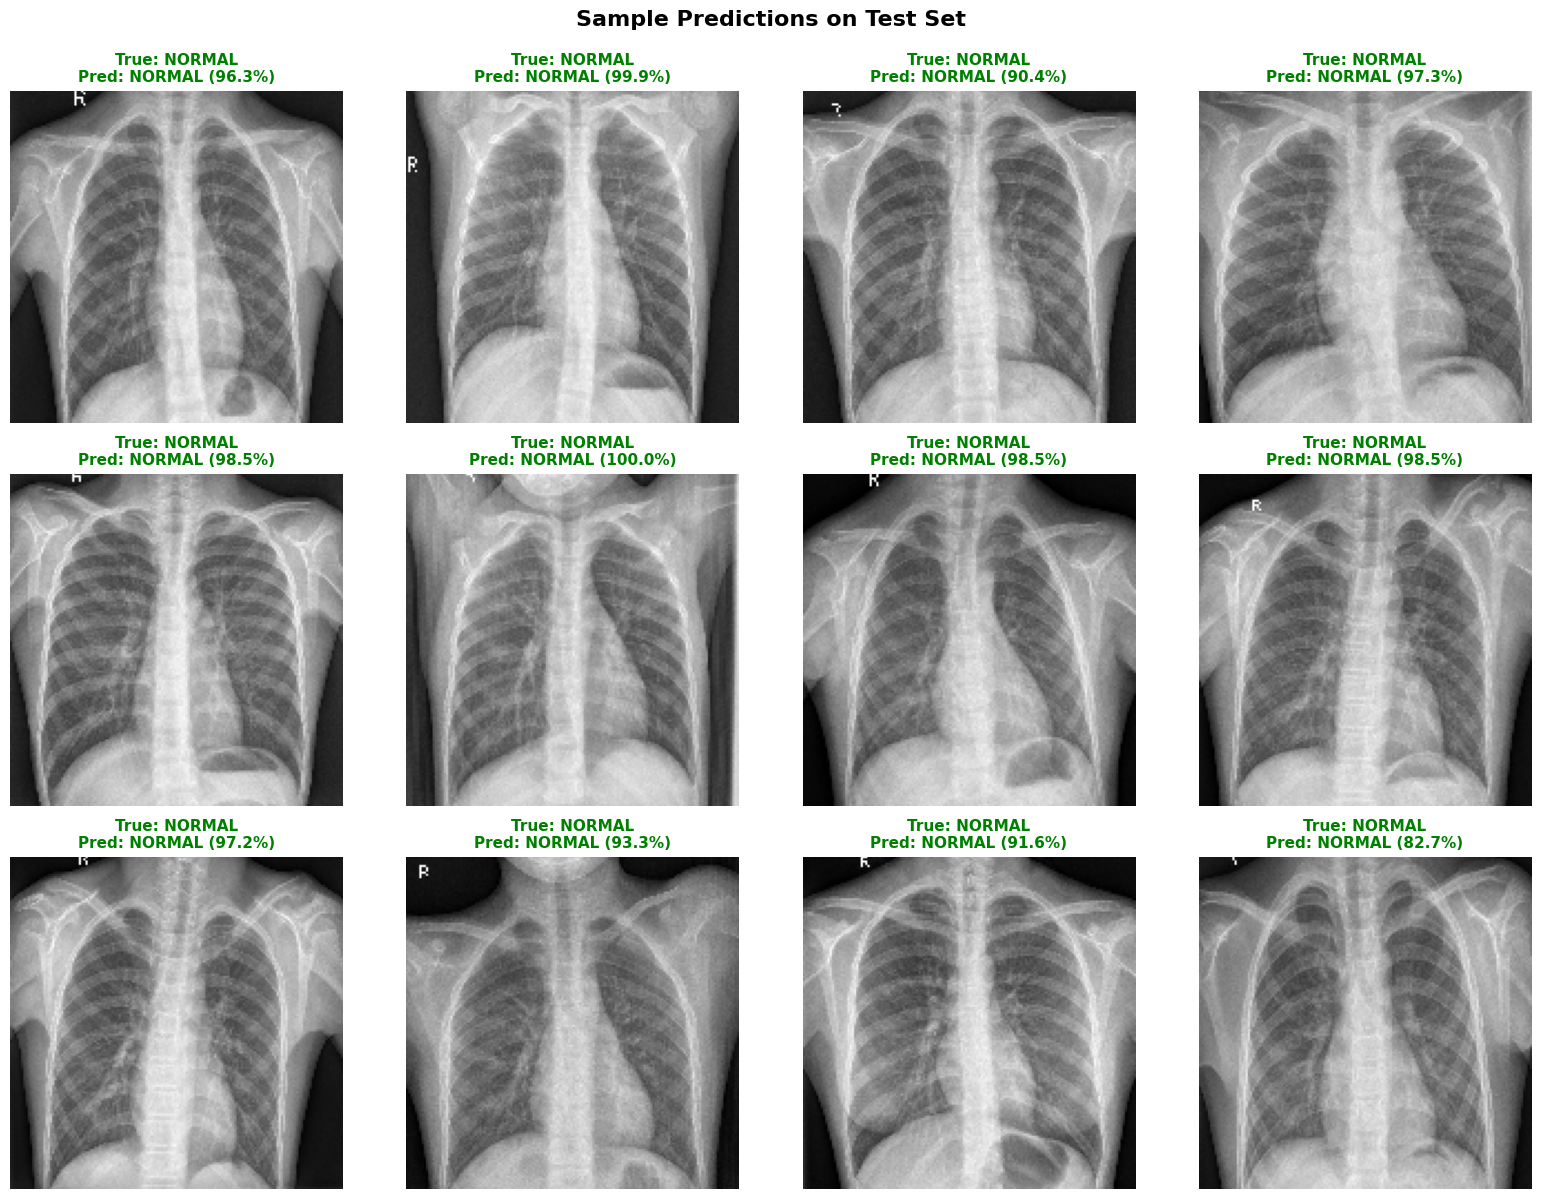

In [11]:
# Visualize some predictions
test_generator.reset()
sample_batch, sample_labels = next(test_generator)
predictions = model.predict(sample_batch, verbose=0)

plt.figure(figsize=(16, 12))
for i in range(min(12, len(sample_batch))):
    plt.subplot(3, 4, i + 1)
    plt.imshow(sample_batch[i], cmap='gray')
    
    true_label = class_names[int(sample_labels[i])]
    pred_prob = predictions[i][0]
    pred_label = class_names[1 if pred_prob > 0.5 else 0]
    confidence = pred_prob if pred_prob > 0.5 else (1 - pred_prob)
    
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label} ({confidence*100:.1f}%)', 
              color=color, fontsize=11, fontweight='bold')
    plt.axis('off')

plt.suptitle('Sample Predictions on Test Set', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Confusion Matrix & Classification Report

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step


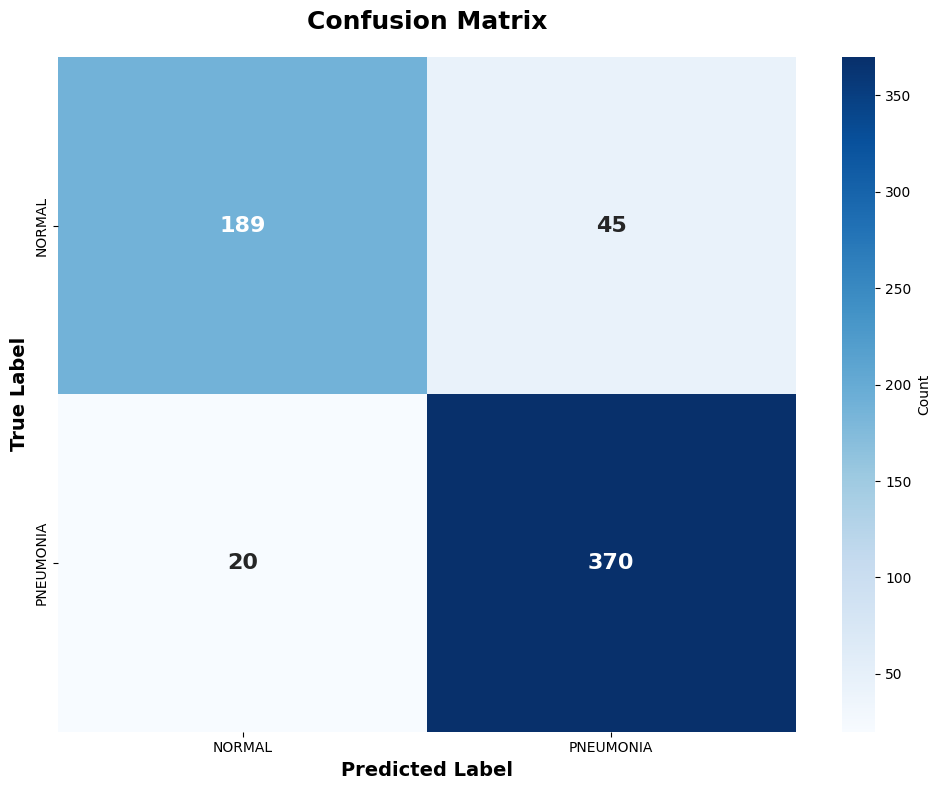


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      NORMAL     0.9043    0.8077    0.8533       234
   PNEUMONIA     0.8916    0.9487    0.9193       390

    accuracy                         0.8958       624
   macro avg     0.8979    0.8782    0.8863       624
weighted avg     0.8963    0.8958    0.8945       624



In [12]:
# Generate predictions
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title('Confusion Matrix', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print("="*60)

# Evaluate on Test Set

In [13]:
# Evaluate model on test data
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)

# Calculate F1 Score
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print(f"\n{'='*60}")
print(f"TEST SET RESULTS:")
print(f"{'='*60}")
print(f"Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test F1-Score:  {f1_score:.4f}")
print(f"Test Loss:      {test_loss:.4f}")
print(f"{'='*60}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.8958 - loss: 0.2863 - precision: 0.8916 - recall: 0.9487

TEST SET RESULTS:
Test Accuracy:  0.8958 (89.58%)
Test Precision: 0.8916
Test Recall:    0.9487
Test F1-Score:  0.9193
Test Loss:      0.2863


# Visualize training history

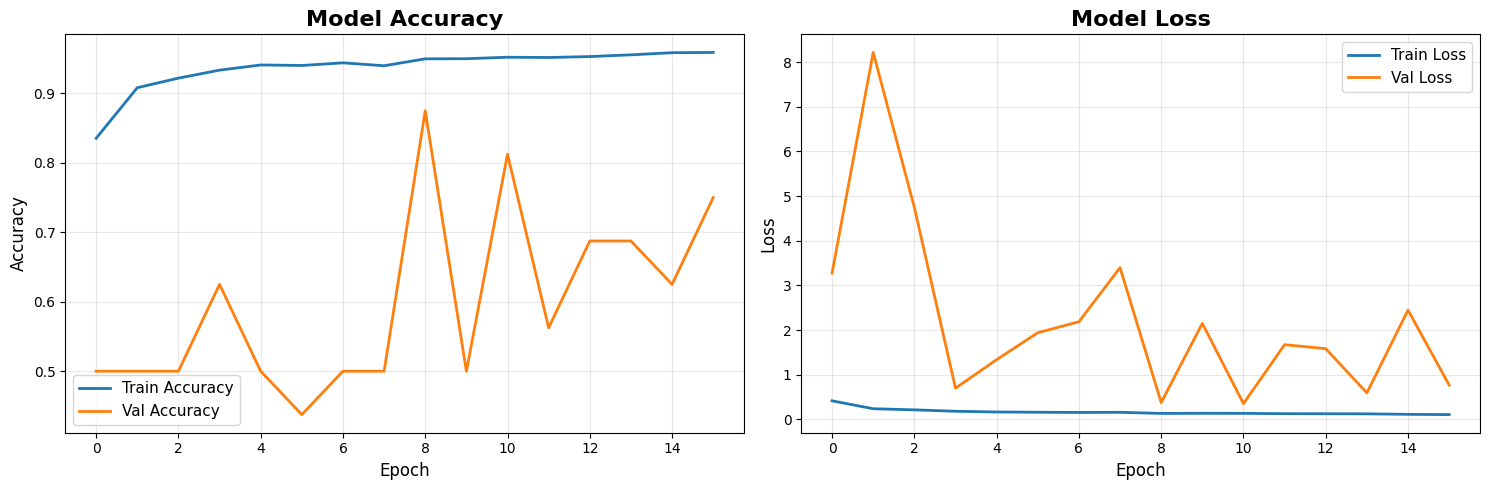

In [14]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()